# train

## load library

In [1]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import mlflow
from collections import defaultdict
from scipy.stats import zscore

# original library

import common as com
import pytorch_modeler as modeler
from pytorch_model import CNN6PANNsAutoEncoder as Model
from pytorch_utils import filtered_load_model
import models

import librosa
import IPython
import librosa.display

ModuleNotFoundError: No module named 'common'

## load config and set logger

In [ ]:
with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

## Setting

In [ ]:
# Setting seed
modeler.set_seed(42)

In [ ]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
PKL_DIR = OUTPUT_ROOT + '/pkl'
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)

# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

## make path list and train/valid split

In [2]:
############################################################################
# make path set and train/valid split
############################################################################
'''
train_paths[machine_type]['train' or 'valid'] = path
'''
dev_train_paths = {}
add_train_paths = {}
train_paths = {}

In [3]:
for machine_type in machine_types:
    # dev train
    dev_train_all_paths = ["{}/{}/train/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(dev_path, machine_type))]
    dev_train_all_paths = sorted(dev_train_all_paths)
    dev_train_paths[machine_type] = {}
    dev_train_paths[machine_type]['train'], \
    dev_train_paths[machine_type]['valid'] = train_test_split(dev_train_all_paths,
                                                              test_size=config['etc']['test_size'],
                                                              shuffle=False,
                                                             )
    # add_dev train
    add_train_all_paths = ["{}/{}/train/".format(add_dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(add_dev_path, machine_type))]
    add_train_all_paths = sorted(add_train_all_paths)
    add_train_paths[machine_type] = {}
    add_train_paths[machine_type]['train'], \
    add_train_paths[machine_type]['valid'] = train_test_split(add_train_all_paths,
                                                              test_size=config['etc']['test_size'],
                                                              shuffle=False,
                                                             )
    train_paths[machine_type] = {}
    train_paths[machine_type]['train'] = dev_train_paths[machine_type]['train'] + add_train_paths[machine_type]['train']
    train_paths[machine_type]['valid'] = dev_train_paths[machine_type]['valid'] + add_train_paths[machine_type]['valid']

NameError: name 'machine_types' is not defined

## training

net = Model(sample_rate=config['preprocessing']['sample_rate'],
            window_size=config['preprocessing']['window_size'],
            hop_size=config['preprocessing']['hop_size'],
            mel_bins=config['preprocessing']['mel_bins'],
            fmin=config['preprocessing']['fmin'],
            fmax=config['preprocessing']['fmax'])

panns_cnn14_path = '/media/hiroki/working/research/dcase2020/pre-trained_model/Cnn14_16k_mAP=0.438.pth'
pretrained_dict = torch.load(panns_cnn14_path)
model = filtered_load_model(net, pretrained_dict)

In [7]:
net = Model(sample_rate=config['preprocessing']['sample_rate'],
            window_size=config['preprocessing']['window_size'],
            hop_size=config['preprocessing']['hop_size'],
            mel_bins=config['preprocessing']['mel_bins'],
            fmin=config['preprocessing']['fmin'],
            fmax=config['preprocessing']['fmax'])

In [8]:
pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_PATH'])
net = filtered_load_model(net, pretrained_dict)

RuntimeError: Error(s) in loading state_dict for CNN6PANNsAutoEncoder:
	size mismatch for spectrogram_extractor.stft.conv_real.weight: copying a param with shape torch.Size([513, 1, 1024]) from checkpoint, the shape in current model is torch.Size([257, 1, 512]).
	size mismatch for spectrogram_extractor.stft.conv_imag.weight: copying a param with shape torch.Size([513, 1, 1024]) from checkpoint, the shape in current model is torch.Size([257, 1, 512]).
	size mismatch for logmel_extractor.melW: copying a param with shape torch.Size([513, 64]) from checkpoint, the shape in current model is torch.Size([257, 64]).

In [9]:
path = '/media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/fan/train/normal_id_00_00000000.wav'
sound_data = com.file_load(path,
                           sr=config['preprocessing']['sample_rate'],
                           mono=config['preprocessing']['mono'])

In [10]:
IPython.display.Audio(data=sound_data[0], rate=sound_data[1])

In [11]:
sound_data[0].shape

(160000,)

In [12]:
hoge = librosa.feature.melspectrogram(y=sound_data[0], sr=sound_data[1], n_fft=1024, hop_length=31,
                                      power=2.0,window='hann',pad_mode='reflect',center=True, n_mels=64,fmin=50,fmax=8000)

In [13]:
#audio = librosa.feature.inverse.mel_to_audio(hoge)

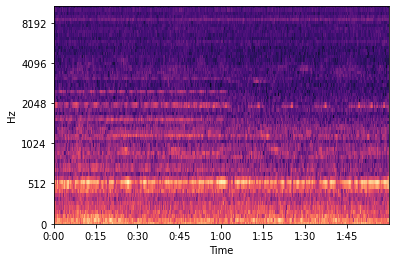

In [14]:
librosa.display.specshow(librosa.power_to_db(hoge,ref=np.max), y_axis='mel', x_axis='time')

In [15]:
from torchsummary import summary
net = net.to('cuda:0')
summary(net, (sound_data[1],)) # summary(model,(channels,H,W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 513, 517]         525,312
            Conv1d-2             [-1, 513, 517]         525,312
       Spectrogram-3          [-1, 1, 517, 513]               0
  LogmelFilterBank-4           [-1, 1, 517, 64]               0
       BatchNorm2d-5           [-1, 64, 512, 1]             128
            Conv2d-6          [-1, 64, 512, 64]           1,600
       BatchNorm2d-7          [-1, 64, 512, 64]             128
      ConvBlock5x5-8          [-1, 64, 256, 32]               0
            Conv2d-9         [-1, 128, 256, 32]         204,800
      BatchNorm2d-10         [-1, 128, 256, 32]             256
     ConvBlock5x5-11         [-1, 128, 128, 16]               0
           Conv2d-12         [-1, 256, 128, 16]         819,200
      BatchNorm2d-13         [-1, 256, 128, 16]             512
     ConvBlock5x5-14           [-1, 256

In [16]:
pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_PATH'])
for key, value in pretrained_dict['model'].items():
    print(key, value.shape)

spectrogram_extractor.stft.conv_real.weight torch.Size([513, 1, 1024])
spectrogram_extractor.stft.conv_imag.weight torch.Size([513, 1, 1024])
logmel_extractor.melW torch.Size([513, 64])
bn0.weight torch.Size([64])
bn0.bias torch.Size([64])
bn0.running_mean torch.Size([64])
bn0.running_var torch.Size([64])
bn0.num_batches_tracked torch.Size([])
conv_block1.conv1.weight torch.Size([64, 1, 5, 5])
conv_block1.bn1.weight torch.Size([64])
conv_block1.bn1.bias torch.Size([64])
conv_block1.bn1.running_mean torch.Size([64])
conv_block1.bn1.running_var torch.Size([64])
conv_block1.bn1.num_batches_tracked torch.Size([])
conv_block2.conv1.weight torch.Size([128, 64, 5, 5])
conv_block2.bn1.weight torch.Size([128])
conv_block2.bn1.bias torch.Size([128])
conv_block2.bn1.running_mean torch.Size([128])
conv_block2.bn1.running_var torch.Size([128])
conv_block2.bn1.num_batches_tracked torch.Size([])
conv_block3.conv1.weight torch.Size([256, 128, 5, 5])
conv_block3.bn1.weight torch.Size([256])
conv_block3

In [17]:
for key, value in pretrained_dict['model'].items():
    print(key, value.shape)

spectrogram_extractor.stft.conv_real.weight torch.Size([513, 1, 1024])
spectrogram_extractor.stft.conv_imag.weight torch.Size([513, 1, 1024])
logmel_extractor.melW torch.Size([513, 64])
bn0.weight torch.Size([64])
bn0.bias torch.Size([64])
bn0.running_mean torch.Size([64])
bn0.running_var torch.Size([64])
bn0.num_batches_tracked torch.Size([])
conv_block1.conv1.weight torch.Size([64, 1, 5, 5])
conv_block1.bn1.weight torch.Size([64])
conv_block1.bn1.bias torch.Size([64])
conv_block1.bn1.running_mean torch.Size([64])
conv_block1.bn1.running_var torch.Size([64])
conv_block1.bn1.num_batches_tracked torch.Size([])
conv_block2.conv1.weight torch.Size([128, 64, 5, 5])
conv_block2.bn1.weight torch.Size([128])
conv_block2.bn1.bias torch.Size([128])
conv_block2.bn1.running_mean torch.Size([128])
conv_block2.bn1.running_var torch.Size([128])
conv_block2.bn1.num_batches_tracked torch.Size([])
conv_block3.conv1.weight torch.Size([256, 128, 5, 5])
conv_block3.bn1.weight torch.Size([256])
conv_block3

In [18]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(train_paths, machine_type)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)         # debug
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    logger.info('TRAINING')
    # parameter setting
    net = Model(sample_rate=config['preprocessing']['sample_rate'],
            window_size=config['preprocessing']['window_size'],
            hop_size=config['preprocessing']['hop_size'],
            mel_bins=config['preprocessing']['mel_bins'],
            fmin=config['preprocessing']['fmin'],
            fmax=config['preprocessing']['fmax'])
    pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_PATH'])
    net = filtered_load_model(net, pretrained_dict)
    optimizer = optim.Adam(net.parameters())
    criterion = nn.MSELoss()
    num_epochs = config['fit']['num_epochs']
    history = modeler.train_net(net, dataloaders_dict, criterion, optimizer, num_epochs, writer)
    # output
    model = history['model']
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    torch.save(model.state_dict(), model_out_path)
    logger.info('\n success:{0} \n'.format(machine_type) + \
                    'model_out_path ==> \n {0}'.format(model_out_path))
    #  close writer for tensorbord
    writer.close()
    #modeler.mlflow_log(history, config, machine_type, model_out_path, tb_log_dir)
    com.toc()
    return history

In [19]:
machine_types

['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

hoge = train_paths[machine_type]['train'][0]

sound_data = com.file_load(hoge,sr=config['preprocessing']['sample_rate'],mono=config['preprocessing']['mono'])

sound_data[0]

In [51]:
for machine_type in machine_types:
    if (machine_type == 'fan') or (machine_type == 'ToyCar') or (machine_type == 'pump'):
        continue
    history = run(machine_type)
    with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
        pickle.dump(history , file)

2020-10-14 13:20:32,615 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2020-10-14 13:20:32,616 - 00_train.py - INFO - MAKE DATA_LOADER
2020-10-14 13:20:32,618 - 00_train.py - INFO - TRAINING
  0%|          | 0/127 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 55/55 [00:25<00:00,  2.16it/s]
2020-10-14 13:22:58,286 - pytorch_modeler.py - INFO - Epoch 1/60:train_loss:0.694016, valid_loss:0.382894
100%|██████████| 55/55 [00:18<00:00,  2.94it/s]
2020-10-14 13:24:39,784 - pytorch_modeler.py - INFO - Epoch 2/60:train_loss:0.322726, valid_loss:0.239005
100%|██████████| 55/55 [00:18<00:00,  2.93it/s]
2020-10-14 13:26:21,498 - pytorch_modeler.py - INFO - Epoch 3/60:train_loss:0.219777, valid_loss:0.162301
100%|██████████| 55/55 [00:18<00:00,  2.96it/s]
2020-10-14 13:28:02,870 - pytorch_modeler.py - INFO - Epoch 4/60:train_loss:0.164889, valid_loss:0.119786
100%|██████████| 55/55 [00:18<00:00,  2.96it/s]
2020-10-14 13:29:44,235 - pytorch_modeler.py - INFO - Epoch 5/60:train_loss:0.128649, valid_loss:0.088233
100%|██████████| 55/55 [00:18<00:00,  2.96it/s]
2020-10-14 13:31:25,624 - pytorch_modeler.py - INFO - Epoch 6/60:train_loss:0.102046, valid_loss:0.071777
100%|██████████| 55/55 [00:18<00:00,  2.96it/s]
2020-10-14 13:33:06,996 - py

elapsed time: 6163.269147396 [sec]


  0%|          | 0/114 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 49/49 [00:23<00:00,  2.07it/s]
2020-10-14 15:05:30,025 - pytorch_modeler.py - INFO - Epoch 1/60:train_loss:0.703645, valid_loss:0.423539
100%|██████████| 49/49 [00:16<00:00,  2.92it/s]
2020-10-14 15:07:02,071 - pytorch_modeler.py - INFO - Epoch 2/60:train_loss:0.314375, valid_loss:0.254736
100%|██████████| 49/49 [00:16<00:00,  2.89it/s]
2020-10-14 15:08:34,100 - pytorch_modeler.py - INFO - Epoch 3/60:train_loss:0.220465, valid_loss:0.180888
100%|██████████| 49/49 [00:16<00:00,  2.92it/s]
2020-10-14 15:10:07,210 - pytorch_modeler.py - INFO - Epoch 4/60:train_loss:0.168061, valid_loss:0.141877
100%|██████████| 49/49 [00:16<00:00,  2.92it/s]
2020-10-14 15:11:38,542 - pytorch_modeler.py - INFO - Epoch 5/60:train_loss:0.134019, valid_loss:0.104431
100%|██████████| 49/49 [00:17<00:00,  2.80it/s]
2020-10-14 15:13:11,793 - pytorch_modeler.py - INFO - Epoch 6/60:train_loss:0.108326, valid_loss:0.084747
100%|██████████| 49/49 [00:17<00:00,  2.85it/s]
2020-10-14 15:14:45,765 - py

KeyboardInterrupt: 

In [ ]:
 if (int(epoch+1) % 10 == 0) or (epoch == 0):
            reconstruct_img['input'].append(x)
            reconstruct_img['output'].append(y)

In [27]:
len(history['reconstruct_img']['input'])

1

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
input_img = history['reconstruct_img']['input'][0].to('cpu')
output_img = history['reconstruct_img']['output'][0].to('cpu')[0,0,:,:]

In [45]:
input_img = input_img[0,0,:,:]

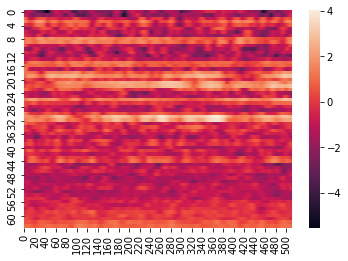

In [47]:
sns.heatmap(input_img.T)

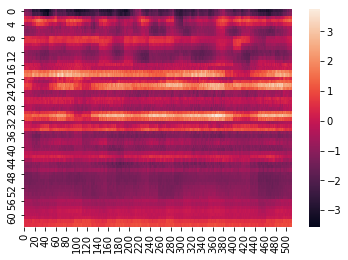

In [50]:
sns.heatmap(output_img.T)

# eval

In [15]:
########################################################################
# import default python-library
########################################################################
import os
import glob
import csv
import re
import itertools
import sys
########################################################################


########################################################################
# import additional python-library
########################################################################
import numpy
from sklearn import metrics
import common as com
import pytorch_modeler as modeler
from pytorch_model import VAE as ae
import torch.utils.data
import yaml
yaml.warnings({'YAMLLoadWarning': False})
########################################################################

In [16]:
########################################################################
# load config
########################################################################
with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [17]:
########################################################################
# Setting seed
########################################################################
modeler.set_seed(42)

In [18]:
########################################################################
# Setting I/O path
########################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
eval_path = INPUT_ROOT + "/eval_test"
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
RESULT_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/result'
os.makedirs(MODEL_DIR, exist_ok=True)

In [19]:
########################################################################
# for original function
########################################################################
param = {}
param["dev_directory"] = dev_path
param["eval_directory"] = eval_path
param["model_directory"] = MODEL_DIR
param["result_directory"] = RESULT_DIR
param["result_file"] = 'result.csv'

In [20]:
########################################################################
# def
########################################################################
def save_csv(save_file_path,
             save_data):
    with open(save_file_path, "w", newline="") as f:
        writer = csv.writer(f, lineterminator='\n')
        writer.writerows(save_data)


def get_machine_id_list_for_test(target_dir,
                                 dir_name="test",
                                 ext="wav"):
    """
    target_dir : str
        base directory path of "dev_data" or "eval_data"
    test_dir_name : str (default="test")
        directory containing test data
    ext : str (default="wav)
        file extension of audio files

    return :
        machine_id_list : list [ str ]
            list of machine IDs extracted from the names of test files
    """
    # create test files
    dir_path = os.path.abspath("{dir}/{dir_name}/*.{ext}".format(dir=target_dir, dir_name=dir_name, ext=ext))
    file_paths = sorted(glob.glob(dir_path))
    # extract id
    machine_id_list = sorted(list(set(itertools.chain.from_iterable(
        [re.findall('id_[0-9][0-9]', ext_id) for ext_id in file_paths]))))
    return machine_id_list


def test_file_list_generator(target_dir,
                             id_name,
                             dir_name="test",
                             prefix_normal="normal",
                             prefix_anomaly="anomaly",
                             ext="wav"):
    """
    target_dir : str
        base directory path of the dev_data or eval_data
    id_name : str
        id of wav file in <<test_dir_name>> directory
    dir_name : str (default="test")
        directory containing test data
    prefix_normal : str (default="normal")
        normal directory name
    prefix_anomaly : str (default="anomaly")
        anomaly directory name
    ext : str (default="wav")
        file extension of audio files

    return :
        if the mode is "development":
            test_files : list [ str ]
                file list for test
            test_labels : list [ boolean ]
                label info. list for test
                * normal/anomaly = 0/1
        if the mode is "evaluation":
            test_files : list [ str ]
                file list for test
    """
    com.logger.info("target_dir : {}".format(target_dir+"_"+id_name))

    # development
    if mode:
        normal_files = sorted(
            glob.glob("{dir}/{dir_name}/{prefix_normal}_{id_name}*.{ext}".format(dir=target_dir,
                                                                                 dir_name=dir_name,
                                                                                 prefix_normal=prefix_normal,
                                                                                 id_name=id_name,
                                                                                 ext=ext)))
        normal_labels = numpy.zeros(len(normal_files))
        anomaly_files = sorted(
            glob.glob("{dir}/{dir_name}/{prefix_anomaly}_{id_name}*.{ext}".format(dir=target_dir,
                                                                                  dir_name=dir_name,
                                                                                  prefix_anomaly=prefix_anomaly,
                                                                                  id_name=id_name,
                                                                                  ext=ext)))
        anomaly_labels = numpy.ones(len(anomaly_files))
        files = numpy.concatenate((normal_files, anomaly_files), axis=0)
        labels = numpy.concatenate((normal_labels, anomaly_labels), axis=0)
        com.logger.info("test_file  num : {num}".format(num=len(files)))
        if len(files) == 0:
            com.logger.exception("no_wav_file!!")
        print("\n========================================")

    # evaluation
    else:
        files = sorted(
            glob.glob("{dir}/{dir_name}/*{id_name}*.{ext}".format(dir=target_dir,
                                                                  dir_name=dir_name,
                                                                  id_name=id_name,
                                                                  ext=ext)))
        labels = None
        com.logger.info("test_file  num : {num}".format(num=len(files)))
        if len(files) == 0:
            com.logger.exception("no_wav_file!!")
        print("\n=========================================")

    return files, labels

In [21]:
mode = 'dev'

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# make output result directory
os.makedirs(RESULT_DIR, exist_ok=True)

# load base directory
dirs = com.select_dirs(param=param, mode=mode)

# initialize lines in csv for AUC and pAUC
csv_lines = []

# loop of the base directory
for idx, target_dir in enumerate(dirs):
    com.logger.info("===========================")
    com.logger.info("[{idx}/{total}] {dirname}".format(
        dirname=target_dir, idx=idx+1, total=len(dirs)))

    machine_type = os.path.split(target_dir)[1]

    com.logger.info("============== MODEL LOAD ==============")

    model_file = "{model}/{machine_type}_model.pth".format(
        model=param["model_directory"],
        machine_type=machine_type)

    if not os.path.exists(model_file):
        com.logger.error("{} model not found ".format(machine_type))
        sys.exit(-1)

    # define AE model
    model = ae().to(device)
    model.eval()
    model.load_state_dict(torch.load(model_file))

    if mode:
        # results by type
        csv_lines.append([machine_type])
        csv_lines.append(["id", "AUC", "pAUC"])
        performance = []

    machine_id_list = get_machine_id_list_for_test(target_dir)

    for id_str in machine_id_list:

        # load list of test files
        test_files, y_true = test_file_list_generator(target_dir, id_str)

        # setup anomaly score file path
        anomaly_score_csv = \
            "{result}/anomaly_score_{machine_type}_{id_str}.csv"\
            .format(result=param["result_directory"],
                    machine_type=machine_type,
                    id_str=id_str)
        anomaly_score_list = []

        com.logger.info(
            "============== BEGIN TEST FOR A MACHINE ID ==============")

        y_pred = [0. for k in test_files]

        for file_idx, file_path in enumerate(test_files):
            try:
                data = com.file_to_vector_array(
                    file_path,
                    n_mels=config["mel_spectrogram_param"]["n_mels"],
                    frames=config["mel_spectrogram_param"]["frames"],
                    n_fft=config["mel_spectrogram_param"]["n_fft"],
                    hop_length=config["mel_spectrogram_param"]["hop_length"],
                    power=config["mel_spectrogram_param"]["power"])

                # reconstruction through auto encoder in pytorch
                feed_data = torch.as_tensor(
                    data, device=device, dtype=torch.float32)
                with torch.no_grad():
                    _, _, pred = model(feed_data, device)
                    pred = pred.to('cpu').detach().numpy().copy()
                    #print(pred)

                errors = numpy.mean(numpy.square(data - pred), axis=1)
                y_pred[file_idx] = numpy.mean(errors)
                anomaly_score_list.append(
                    [os.path.basename(file_path), y_pred[file_idx]])
            except FileNotFoundError:
                com.logger.error("file broken!!: {}".format(file_path))

        # save anomaly score
        save_csv(save_file_path=anomaly_score_csv,
                    save_data=anomaly_score_list)
        com.logger.info(
            "anomaly score result ->  {}".format(anomaly_score_csv))

        if mode:
            # append AUC and pAUC to lists
            auc = metrics.roc_auc_score(y_true, y_pred)
            p_auc = metrics.roc_auc_score(
                y_true, y_pred, max_fpr=config["etc"]["max_fpr"])
            csv_lines.append([id_str.split("_", 1)[1], auc, p_auc])
            performance.append([auc, p_auc])
            com.logger.info("AUC : {}".format(auc))
            com.logger.info("pAUC : {}".format(p_auc))

        com.logger.info(
            "============ END OF TEST FOR A MACHINE ID ============")

    if mode:
        # calculate averages for AUCs and pAUCs
        averaged_performance = numpy.mean(
            numpy.array(performance, dtype=float), axis=0)
        csv_lines.append(["Average"] + list(averaged_performance))
        csv_lines.append([])

if mode:
    # output results
    result_path = "{result}/{file_name}".format(
        result=param["result_directory"],
        file_name=param["result_file"])
    com.logger.info("AUC and pAUC results -> {}".format(result_path))
    save_csv(save_file_path=result_path, save_data=csv_lines)

2020-09-22 19:40:16,241 - INFO - load_directory <- development
2020-09-22 19:40:16,243 - INFO - ===========================
2020-09-22 19:40:16,244 - INFO - [1/6] /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/ToyCar
2020-09-22 19:40:16,245 - INFO - ============== MODEL LOAD ==============
2020-09-22 19:40:16,283 - INFO - target_dir : /media/hiroki/working/research/dcase2020/datasets/DCASE2/dev_data/ToyCar_id_01
2020-09-22 19:40:16,291 - INFO - test_file  num : 601
2020-09-22 19:40:16,292 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
/home/hiroki/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



tensor(1064.9595, device='cuda:0')


ValueError: too many values to unpack (expected 3)